In [113]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()


scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.2 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3
squidpy==1.0.0


Adding image layer `image`


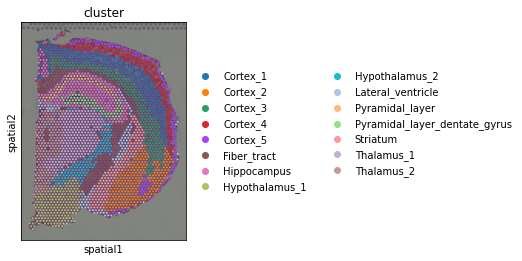

In [5]:
sc.pl.spatial(adata, color="cluster")

In [6]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img,
        features="summary",
        key_added=feature_name,
        n_jobs=1,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f], axis="columns"
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

  0%|          | 0/2688 [00:00<?, ?/s]

/home/dbdimitrov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


  0%|          | 0/2688 [00:00<?, ?/s]

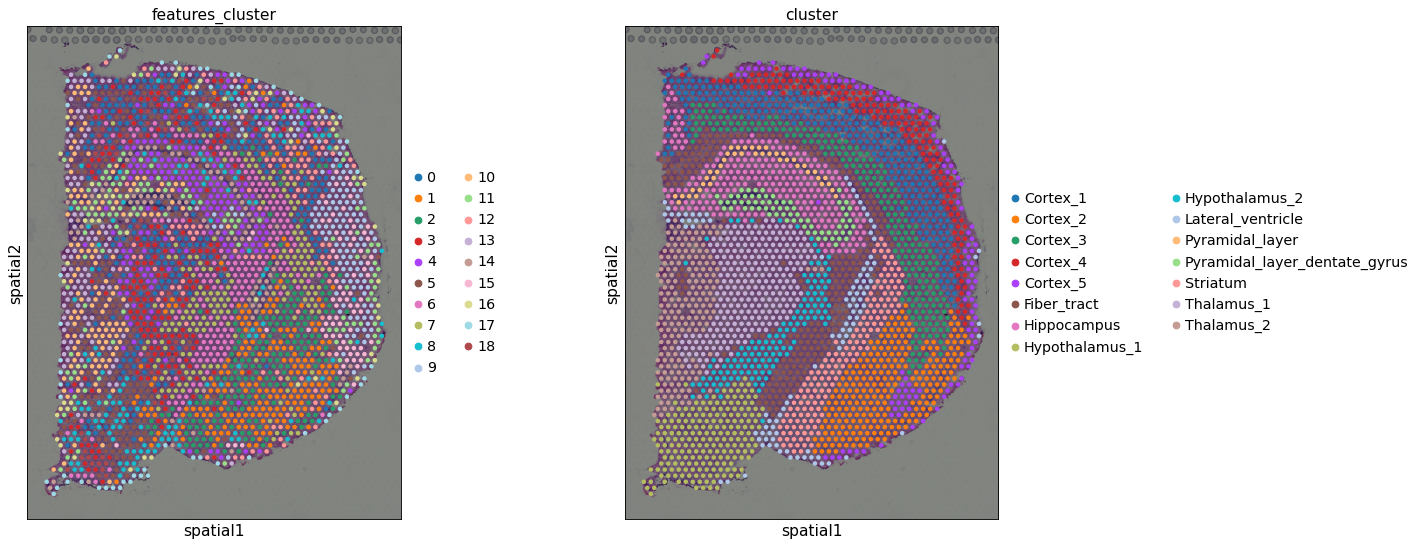

In [7]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None):
    """Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color=["features_cluster", "cluster"])

  0%|          | 0/1000 [00:00<?, ?/s]

/home/dbdimitrov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


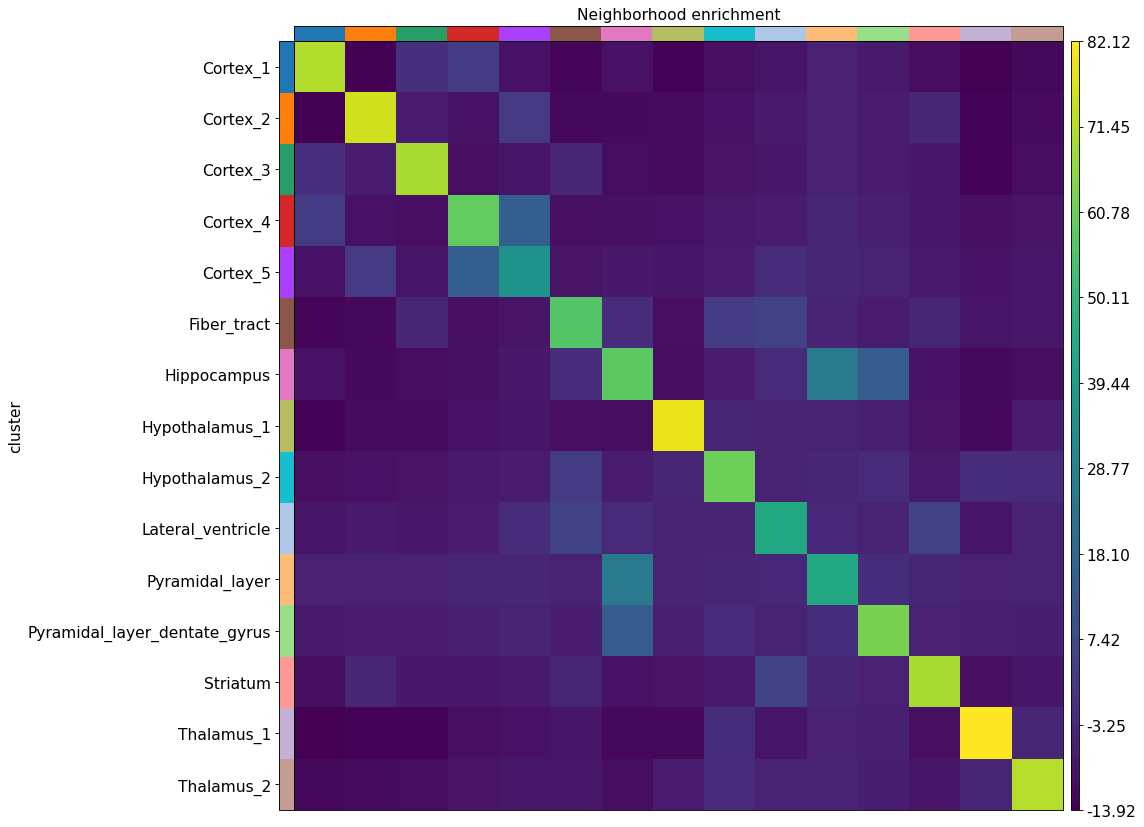

In [8]:
# Neighborhood enrichment
sq.gr.spatial_neighbors(adata) # create a graph from spatial coordinates
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster")

In [21]:
sq.gr.nhood_enrichment(adata, cluster_key="cluster", copy=True)

  0%|          | 0/1000 [00:00<?, ?/s]

(array([[ 69.03680854, -13.82398633,  -0.4011234 ,   3.03149725,
          -9.3643766 , -12.42971906,  -8.82032926, -12.30901354,
          -9.53612391,  -8.69703636,  -5.24935639,  -6.66997374,
         -10.58803913, -13.86869997, -12.40739262],
        [-13.82398633,  74.8981149 ,  -6.28300815,  -9.45606175,
           1.95045009, -12.26958826, -12.39647761, -11.9538035 ,
          -9.02326131,  -7.01006491,  -4.91021458,  -6.6459381 ,
          -3.48557651, -12.74919202, -11.47839892],
        [ -0.4011234 ,  -6.28300815,  70.84758244,  -9.90289032,
          -8.31439713,  -3.54024048, -11.13306788, -11.3755739 ,
          -9.11222709,  -8.22846187,  -4.89407993,  -6.24859713,
          -7.30344329, -12.59300874, -10.66724537],
        [  3.03149725,  -9.45606175,  -9.90289032,  59.48567013,
          14.76221182,  -9.44821578,  -9.50643613,  -9.02355836,
          -7.40349068,  -6.42236047,  -4.12622743,  -4.952787  ,
          -7.81386911, -10.17615413,  -8.84274362],
        [ -9

In [20]:
help(sq.gr.nhood_enrichment)

Help on function nhood_enrichment in module squidpy.gr._nhood:

nhood_enrichment(adata: anndata._core.anndata.AnnData, cluster_key: str, connectivity_key: Union[str, NoneType] = None, n_perms: int = 1000, numba_parallel: bool = False, seed: Union[int, NoneType] = None, copy: bool = False, n_jobs: Union[int, NoneType] = None, backend: str = 'loky', show_progress_bar: bool = True) -> Union[Tuple[numpy.ndarray, numpy.ndarray], NoneType]
    Compute neighborhood enrichment by permutation test.
    
    Parameters
    ----------
    adata
        Annotated data object.
    cluster_key
        Key in :attr:`anndata.AnnData.obs` where clustering is stored.
    connectivity_key
        Key in :attr:`anndata.AnnData.obsp` where spatial connectivities are stored.
    n_perms
        Number of permutations for the permutation test.
    numba_parallel
        Whether to use :class:`numba.prange` or not. If `None`, it is determined automatically.
        For small datasets or small number of intera

  0%|          | 0/1 [00:00<?, ?/s]

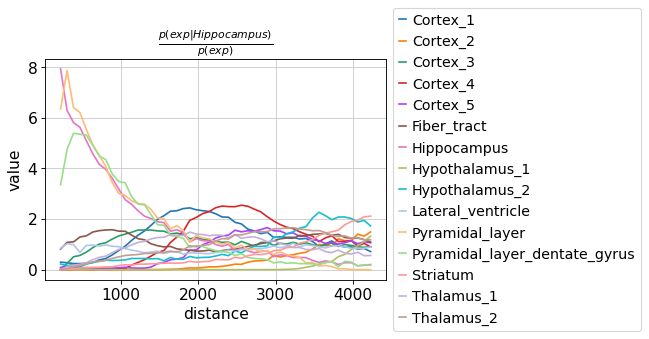

In [17]:
sq.gr.co_occurrence(adata, cluster_key="cluster", copy=True)
sq.pl.co_occurrence(
    adata,
    cluster_key="cluster",
    clusters="Hippocampus",
    figsize=(8, 4),
)

In [11]:
help(sq.gr.co_occurrence)

Help on function co_occurrence in module squidpy.gr._ppatterns:

co_occurrence(adata: anndata._core.anndata.AnnData, cluster_key: str, spatial_key: str = 'spatial', n_steps: int = 50, copy: bool = False, n_splits: Union[int, NoneType] = None, n_jobs: Union[int, NoneType] = None, backend: str = 'loky', show_progress_bar: bool = True) -> Union[Tuple[numpy.ndarray, numpy.ndarray], NoneType]
    Compute co-occurrence probability of clusters.
    
    The co-occurrence is computed across ``n_steps`` distance thresholds in spatial dimensions.
    
    Parameters
    ----------
    adata
        Annotated data object.
    cluster_key
        Key in :attr:`anndata.AnnData.obs` where clustering is stored.
    spatial_key
        Key in :attr:`anndata.AnnData.obsm` where spatial coordinates are stored.
    n_steps
        Number of distance thresholds at which co-occurrence is computed.
    
    copy
        If `True`, return the result, otherwise save it to the ``adata`` object.
    n_splits
  

In [ ]:
# Load Seurat object

In [23]:
import anndata2ri
import rpy2
import re
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 7.2.0
PyQt5               NA
affine              2.3.0
anndata             0.7.5
anndata2ri          1.0.6
asciitree           NA
attr                20.3.0
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
bs4                 4.9.1
certifi             2020.06.20
cffi                1.14.5
chardet             3.0.4
click               7.1.2
cloudpickle         1.5.0
colorama            0.4.3
cycler              0.10.0
cython_runtime      NA
cytoolz             0.10.1
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
distributed         2.20.0
docrep              0.3.2
esda                2.3.6
fasteners           NA
get_version         2.1
h5py                3.1.0
html5lib            1.1
idna                2.10
igraph              0.8.3
imageio             2.9.0
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi

In [28]:
%%R
library(Seurat)
library(SingleCellExperiment)
sdata <- readRDS("~/Repos/ligrec_decoupleR/input/sc_bc/breast_cancer_seurat323.rds")

In [29]:
%%R -o sdata_sce
#convert the Seurat object to a SingleCellExperiment object
sdata_sce <- as.SingleCellExperiment(sdata)

sdata_sce

class: SingleCellExperiment 
dim: 19674 4325 
metadata(0):
assays(2): X logcounts
rownames(19674): AL627309.1 AL627309.5 ... AC007325.4 AC007325.2
rowData names(9): sct.detection_rate sct.gmean ...
  markvariogram.spatially.variable
  markvariogram.spatially.variable.rank
colnames(4325): AAACAACGAATAGTTC-1 AAACAAGTATCTCCCA-1 ...
  TTGTTTCCATACAACT-1 TTGTTTGTGTAAATTC-1
colData names(8): orig.ident nCount_Spatial ... seurat_clusters ident
reducedDimNames(2): PCA UMAP
altExpNames(0):


In [30]:
sdata_sce

AnnData object with n_obs × n_vars = 4325 × 19674
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'ident'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable', 'r.metric.5', 'markvariogram.spatially.variable', 'markvariogram.spatially.variable.rank'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [48]:
import os
os.path.abspath(os.getcwd())

'/home/dbdimitrov/Repos/ligrec_decoupleR/scripts/test'

In [87]:
adata = sc.read_visium('/home/dbdimitrov/Repos/ligrec_decoupleR/input/human_breast_cancer',
                       count_file="filtered.h5")

reading /home/dbdimitrov/Repos/ligrec_decoupleR/input/human_breast_cancer/filtered.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [88]:
adata

AnnData object with n_obs × n_vars = 4325 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [89]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [90]:
adata

AnnData object with n_obs × n_vars = 4325 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

/home/dbdimitrov/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dbdimitrov/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dbdimitrov/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<AxesSubplot:xlabel='n_genes_by_counts'>

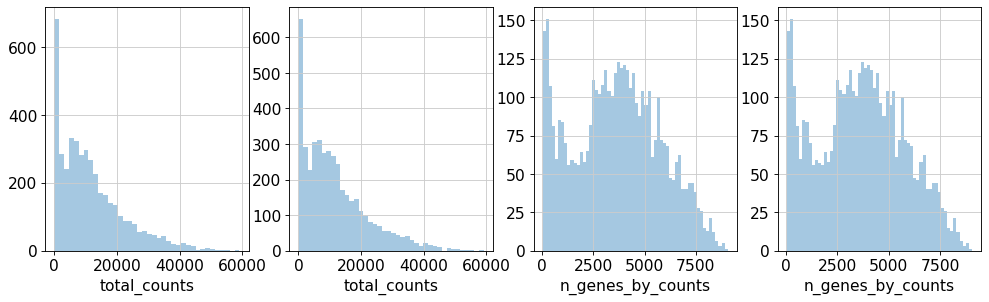

In [91]:
# QC and Processing
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 100000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 10000], kde=False, bins=60, ax=axs[3])

In [98]:
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_cells(adata, max_counts=45000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

/home/dbdimitrov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/dbdimitrov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.var` of view, copying.


#cells after MT filter: 3962


/home/dbdimitrov/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dbdimitrov/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dbdimitrov/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<AxesSubplot:xlabel='n_genes_by_counts'>

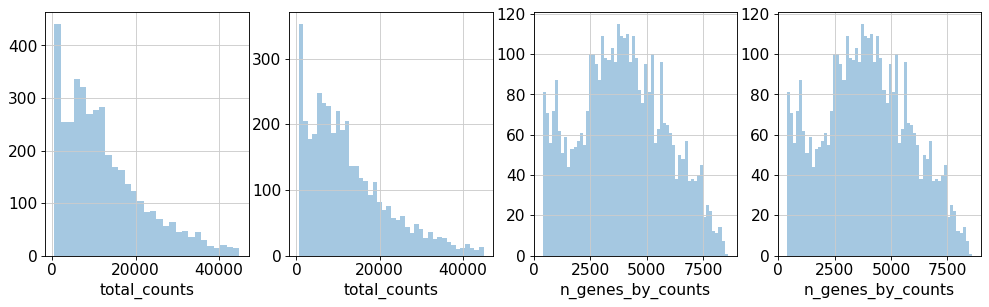

In [99]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 100000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 10000], kde=False, bins=60, ax=axs[3])

In [100]:
# Normalize and HVF
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [101]:
# Manifold embedding and clustering based on transcriptional similarity
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

computing PCA
    on highly variable genes
/home/dbdimitrov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 9 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


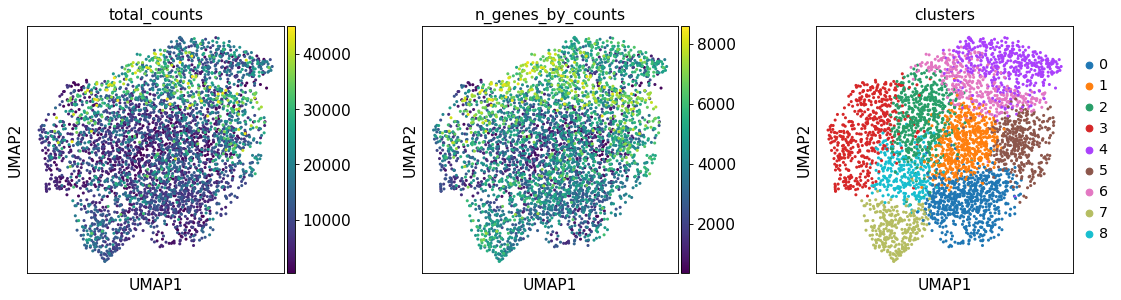

In [102]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

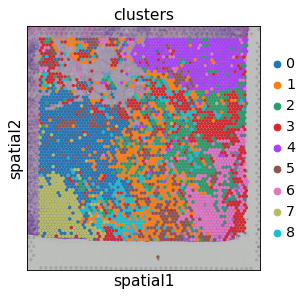

In [103]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

In [110]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="clusters")

Creating graph using `visium` coordinates and `None` transform
Adding `adata.obsp['spatial_connectivities']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['clusters_nhood_enrichment']`
Finish (0:00:00)


IndexError: positional indexers are out-of-bounds

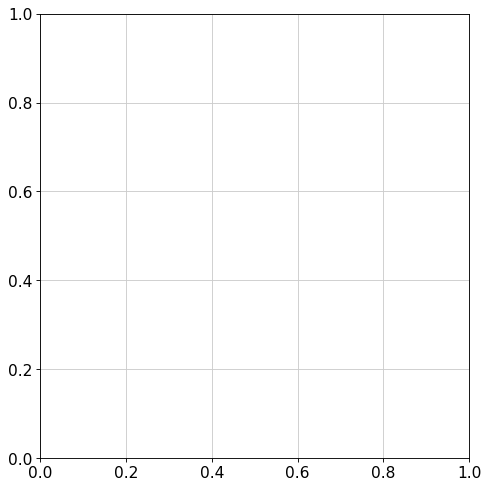

In [111]:
sq.pl.nhood_enrichment(adata, cluster_key="clusters")

In [112]:
sq.gr.nhood_enrichment(adata, cluster_key="clusters", copy=True)

Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

(array([[ 6.36463709e+01, -1.08468464e+01, -1.89270396e+01,
         -1.82677193e+01, -2.32443750e+01, -2.05279765e+00,
         -1.98987722e+01, -2.12883197e+00, -3.84199818e+00],
        [-1.08468464e+01,  2.66606123e+01,  9.95349609e-01,
         -1.47511810e+01, -1.45744355e+01,  1.70782425e+01,
         -1.27086302e+01, -1.44145916e+01,  9.17416648e+00],
        [-1.89270396e+01,  9.95349609e-01,  3.64646114e+01,
         -3.80739810e-02, -9.65984848e+00, -1.13246516e+01,
          4.06473971e+00, -1.43804330e+01,  1.66183223e-01],
        [-1.82677193e+01, -1.47511810e+01, -3.80739810e-02,
          4.30459045e+01, -1.50698298e+01, -1.03024725e+01,
         -2.68376953e+00, -1.17426110e+01,  3.42749376e+00],
        [-2.32443750e+01, -1.45744355e+01, -9.65984848e+00,
         -1.50698298e+01,  7.45662313e+01, -8.90112144e+00,
         -8.41201869e+00, -1.47439865e+01, -1.37406957e+01],
        [-2.05279765e+00,  1.70782425e+01, -1.13246516e+01,
         -1.03024725e+01, -8.901121